Let's compare prices from Bidfood

In [1]:
import os
import glob
import numpy as np
import pdfplumber
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
import openpyxl

In [2]:
#Import the data 
folder_path = str(os.getcwd())
pdf_files = []

# Iterate over PDF files in the folder
for file_path in glob.glob(folder_path + "/files/*.pdf"):
    # Extract the file name from the file path
    file_name = file_path.split("/")[-1]
    
    # Add the file name and creation time to the list
    pdf_files.append(file_name)

# Print the list of PDF file names and their creation dates
#print(pdf_files)


In [22]:
os.chdir(folder_path+"/files") #change directory to files folder

def process_invoices(pdf_files, brand_names, extra_quantity_marker):
    df_pd = pd.DataFrame()
    df_total = pd.DataFrame()
    df_quantity = pd.DataFrame()

    num_of_errors=0
    for file in pdf_files:
        #print(f"Processing: {file}.")
        with pdfplumber.open(file) as pdf:
            text = pdf.pages[0].extract_text()
            #print(f"Processing date...")
            # Find the invoice date
            date_line = [line for line in text.split('\n') if 'Afleverdatum' in line]
            if not date_line:
                print(f"No invoice date found in {file}")
                continue
            date_str = date_line[0].split()[-1]
            invoice_date = datetime.strptime(date_str, '%d-%m-%Y').date()
            for i in range(len(pdf.pages)): 
                #print(f"Processing page {i+1} of {len(pdf.pages)}")
                # Extract text from the PDF
                text = pdf.pages[i].extract_text()

                # Find the table with item prices
                table_start = [i for i, line in enumerate(text.split('\n')) if 'artikel aantal be inhoud eh colli merk artikelomschrijving inhoud adviesprijs' in line]
                if not table_start:
                    #print(f"No item table found in {file}")
                    continue
                table_start = table_start[0]
                
                # Extract item information, quantity, and prices
                items = []
                quantities = []
                prices = []
                ppqs = []
                total_paid = None
                lines = text.split('\n')[table_start+1:]
                for line in lines:
                    if not line.strip():
                        break
                    parts = line.split()
                    if len(parts) < 4:
                        continue  # Skip lines without enough categories
                    
                    # Find the brand name
                    brand_name = None
                    for brand in brand_names:
                        if brand in line:
                            brand_name = brand
                            break
                    if not brand_name:
                        continue
                    
                    # Extract the product name between the brand name and the last two parts
                    product_parts = parts[parts.index(brand_name) + 1:-2]   
                    item = ' '.join(product_parts)
                    quantity = parts[1].replace(',', '.')
                    if parts[4] in extra_quantity_marker:
                        #print(f"parts[4]: {parts[4]}, parts[3]: {parts[3].replace(',', '.')}")
                        quantity = float(parts[1].replace(',','.'))*float(parts[3].replace(',', '.'))
                    if parts[1]==str('B'): #this is corner case for some dates
                        quantity = parts[2].replace(',', '.')
                    
                    price = parts[-1].replace(',', '.')

                    try:
                        ppq= round(float(price)/float(quantity),2)
                    except ValueError:
                        break

                    if parts[2]=='KG':
                        #kg chnages the interpretation of the price per quantity
                        quantity = float(parts[1].replace(',','.'))
                        ppq=round(float(price)/quantity,2)

                    try:
                        price = float(price)
                        items.append(item)
                        quantities.append(quantity)
                        prices.append(price)
                        ppqs.append(ppq)
                    except ValueError:
                        print(f"Skipping line: {line}")
                
                try:
                    eval_var= round(float(price)/float(quantity),2)
                except ValueError:
                    num_of_errors+=1
                    #print(f"No prices. Check {file}")
                    break

                # Find the total price
                total_line = [line for line in text.split('\n') if 'Totaal' in line]
                if not total_line:
                    #print(f"No total price found in {file}")
                    continue
                elif len(total_line[0].split())>1:
                    total_line = total_line[0].split()
                    total_paid = float(total_line[-1].replace(',', '.'))
                    
                # Create a DataFrame for item prices over time
                data = {'Date': [invoice_date] * len(items), 'Item': items, 'Quantity': quantities, 'Price': prices, 'PPQ': ppqs}
                df = pd.DataFrame(data)
                df_pd=pd.concat([df_pd, df],ignore_index=True,axis=0)

                #Create a DataFrame for quantity over time
                df_quantity_add = pd.DataFrame({'Date': [invoice_date] * len(items), 'Item': items, 'Quantity': quantities})
                df_quantity=pd.concat([df_quantity, df_quantity_add],ignore_index=True,axis=0)

                # Add the total price to the DataFrame
                df_total_add = pd.DataFrame({'Date': [invoice_date], 'Total price': [total_paid]})
                df_total=pd.concat([df_total, df_total_add],ignore_index=True,axis=0)
        
        
        #print(f"Succesfully processed {file}")

    #print(f"Number of errors: {num_of_errors}")
    #print(f"Number of invoices processed: {len(pdf_files)-num_of_errors}")
    df_total=df_total.dropna()
    #print(f"Success rate: {round((len(pdf_files)-num_of_errors)/len(pdf_files)*100,2)}%"")
    return df_pd, df_total, df_quantity     

            


In [4]:
brand_names = ['BAUER', 'BRAV.E', 'ECHTBO','MEAPRE','BROU','ERU','SMARTC','FINLEY','CHAUDF','CHIO','REMIA','NUTELL','PSC.TO','SELEC','CAMBIO','GROLS.','OORDT',"PSC.DI","CUBY","KOOPMA","ROCCOB",'TRADIL','LIPTON','DNUTS','HEINEK','DROGHE','KELLOG','FUZE','REMIA','VGILSE','COS&TR','CHIO','OATLY','PRINGL','CORONA','BETTIN','AMEFA','BOMBAY','DEBIC','ECHTBO','KELLOG','FANTA','HOTCE','OMO','OORDT','BELAS','SPA','PRINGL','BACARD','SOURCY','FAIRTR','SNICKE','TRADIL','SMOKYM','BOMBAY','J.DANI','MARTEL','LILAS']
extra_quantity_marker=['PK','BE','DJ','FL','FL','BS','CP','BL',"PT",'ZJ','BB','ST','BS','WL','ZK']

In [5]:
df, df_total, df_quantity=process_invoices(pdf_files, brand_names,extra_quantity_marker)

In [6]:
# Group by "Item" and calculate the average price per item
df=pd.DataFrame(df)
df_pivot = df.reset_index().pivot_table(index='Item', columns='Date', values='PPQ')

In [7]:
#print(df_pivot)

In [8]:
df_pivot.to_excel('df_pivot.xlsx', index=True)
df_total.sort_values("Date").to_excel('df_total.xlsx', index=True)

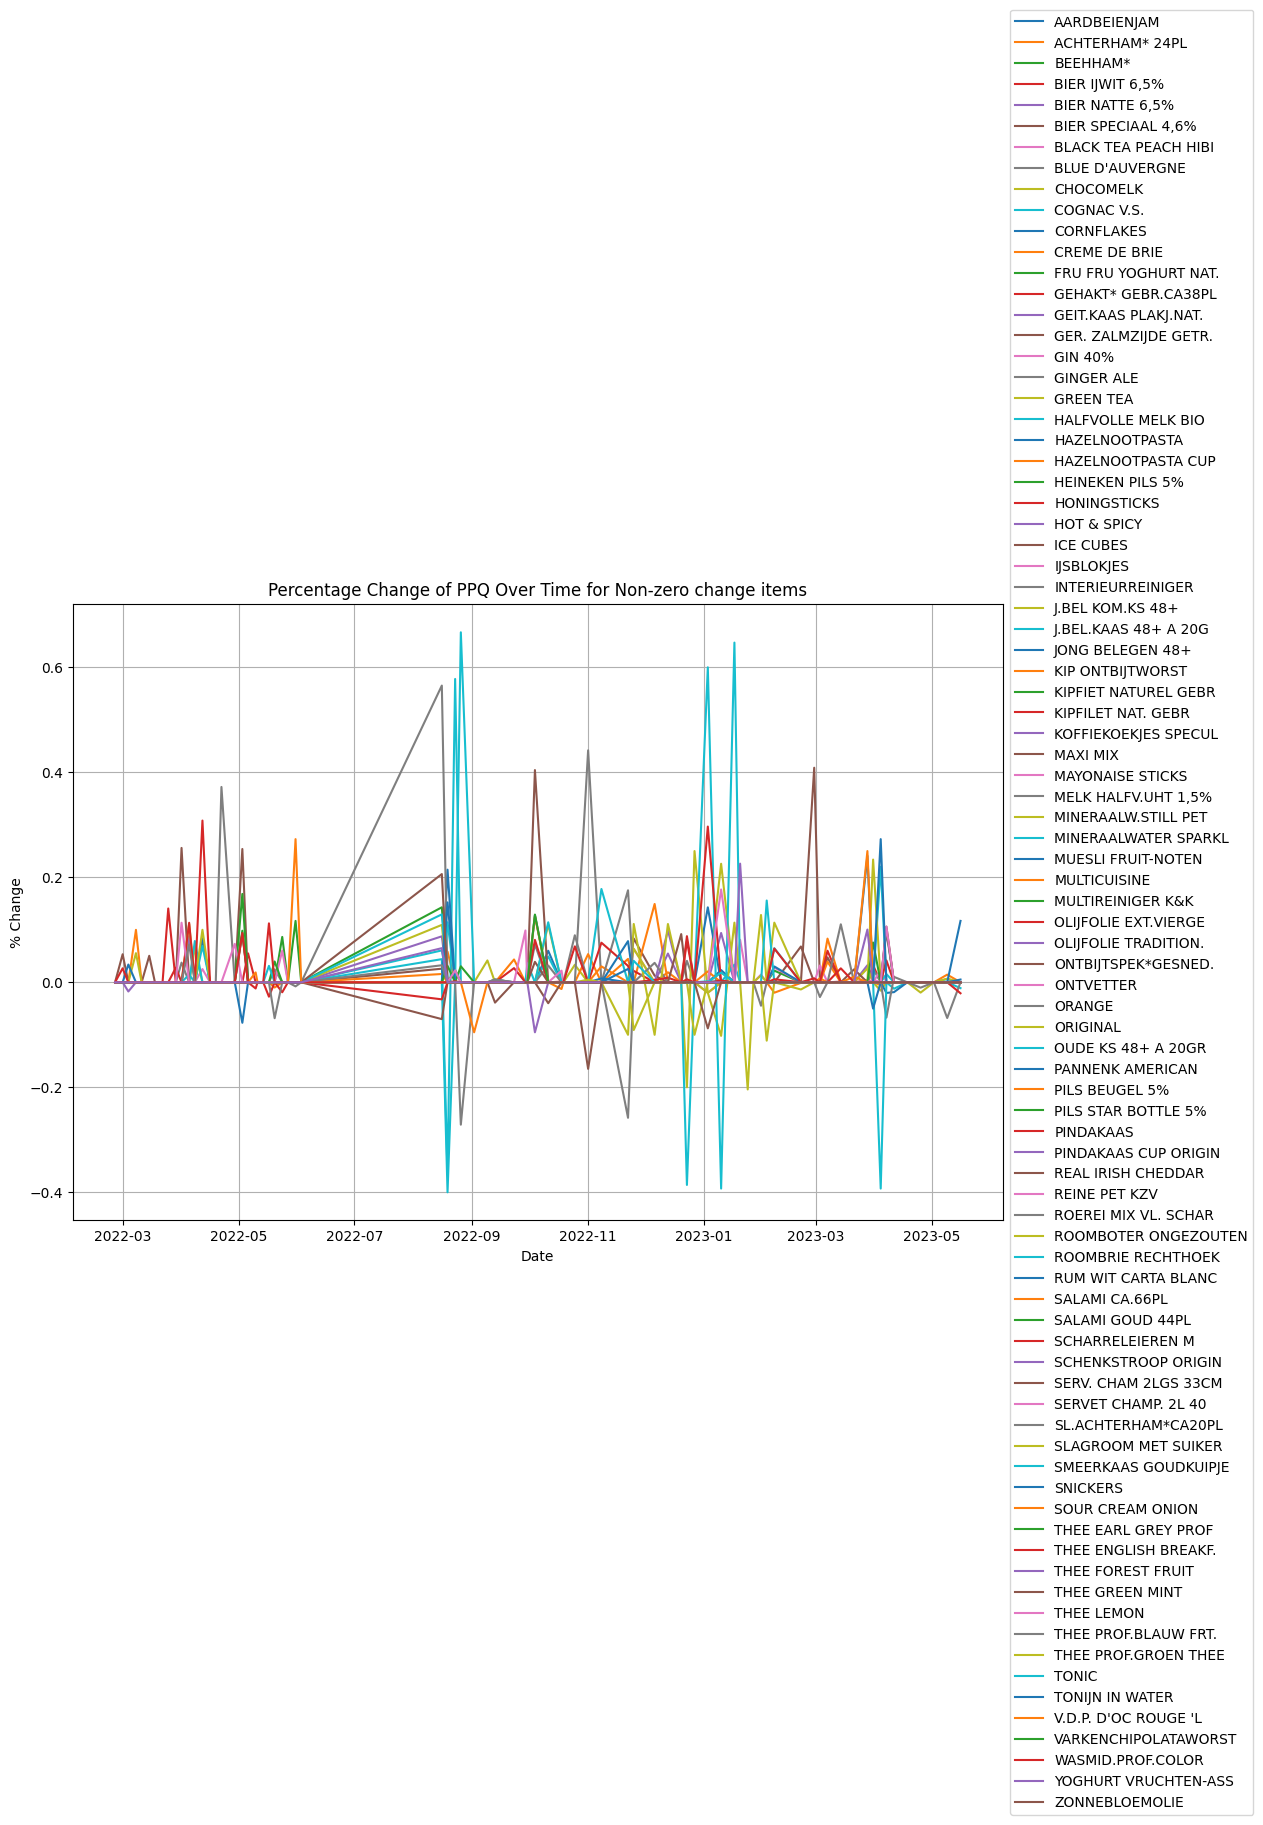

In [9]:

import matplotlib.pyplot as plt

# Calculate the percentage change for each item
df_pct_change = df_pivot.pct_change(axis=1)
df_pct_change = df_pct_change.loc[df_pct_change.abs().sum(axis=1) != 0]

# Plotting the percentage change for each item
df_pct_change.T.plot(figsize=(12, 8))
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title('Percentage Change of PPQ Over Time for Non-zero change items')       
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

This graph isn't particularly useful due to the sheer amount of information that is displayed and also the fact that it is in percent. Besides this and the following graph only real cummulative change is considered as something like a water can be 30 cents and an increase of 10 cents is massive in percentage terms, but actually insignificant for the bill.

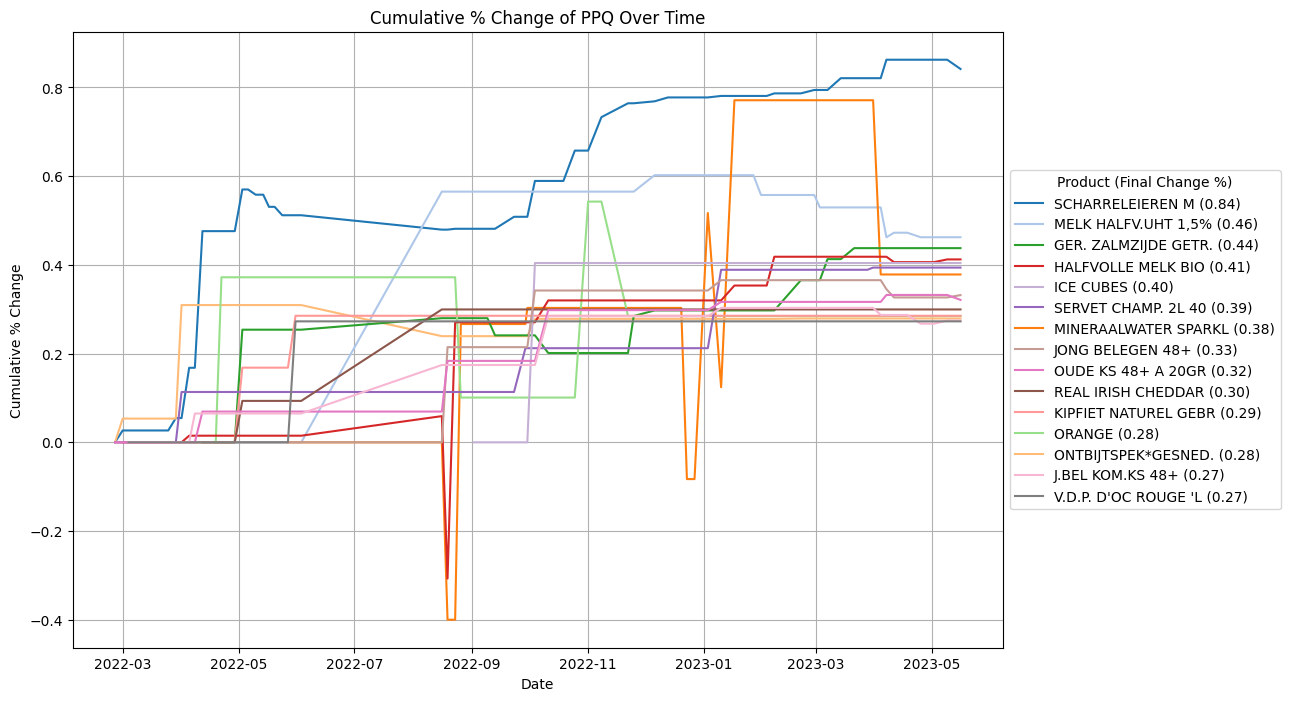

In [10]:


# Calculate the cumulative percentage change for each item
df_cum_pct_change = df_pivot.pct_change(axis=1).cumsum(axis=1)
df_cum_pct_change = df_cum_pct_change.loc[df_cum_pct_change.abs().sum(axis=1) != 0]

# Select the top 15 items with the biggest cumulative changes
top_15_cum_changes = df_cum_pct_change.abs().sum(axis=1).nlargest(15).index
#top_15_cum_changes = top_15_cum_changes.drop("MUESLI FRUIT-NOTEN")
df_top_15_cum_changes = df_cum_pct_change.loc[top_15_cum_changes]

# Plotting the cumulative percentage change for the top 15 items

fig, ax = plt.subplots(figsize=(12, 8))
final_changes = []


# Define colors for lines and legend entries
colors = plt.cm.tab20(range(len(df_top_15_cum_changes.index)))

for idx, item in enumerate(df_top_15_cum_changes.index):
    line_color = colors[idx]
    line, = ax.plot(df_top_15_cum_changes.columns, df_top_15_cum_changes.loc[item], color=line_color)
    final_change = df_top_15_cum_changes.loc[item].iloc[-1]
    final_changes.append(final_change)
    line.set_label(f"{item} ({final_change:.2f})")

# Sort the legend labels by final changes
legend_labels = [line.get_label() for line in ax.lines]
sorted_legend_labels = [label for _, label in sorted(zip(final_changes, legend_labels), reverse=True)]
sorted_lines = [line for _, line in sorted(zip(final_changes, ax.lines), reverse=True)]

# Create a separate legend with sorted labels and final changes
plt.legend(handles=sorted_lines, labels=sorted_legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Product (Final Change %)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative % Change')
ax.set_title('Cumulative % Change of PPQ Over Time')
ax.grid(True)

plt.show()


The following 3 graphs are the top 15, 25 and all non-zero items.
- The first gived some graphical intuition about how did price change over time for the top 15 items and we can notice a couple of interesting things like how much more volatile the price of eggs is.
- The second is really the summary of the top 25 
- The last is meant to be viewed purely as a legend and to notice any abnormal values (its main use was for altering the function and cleaning the data)
 

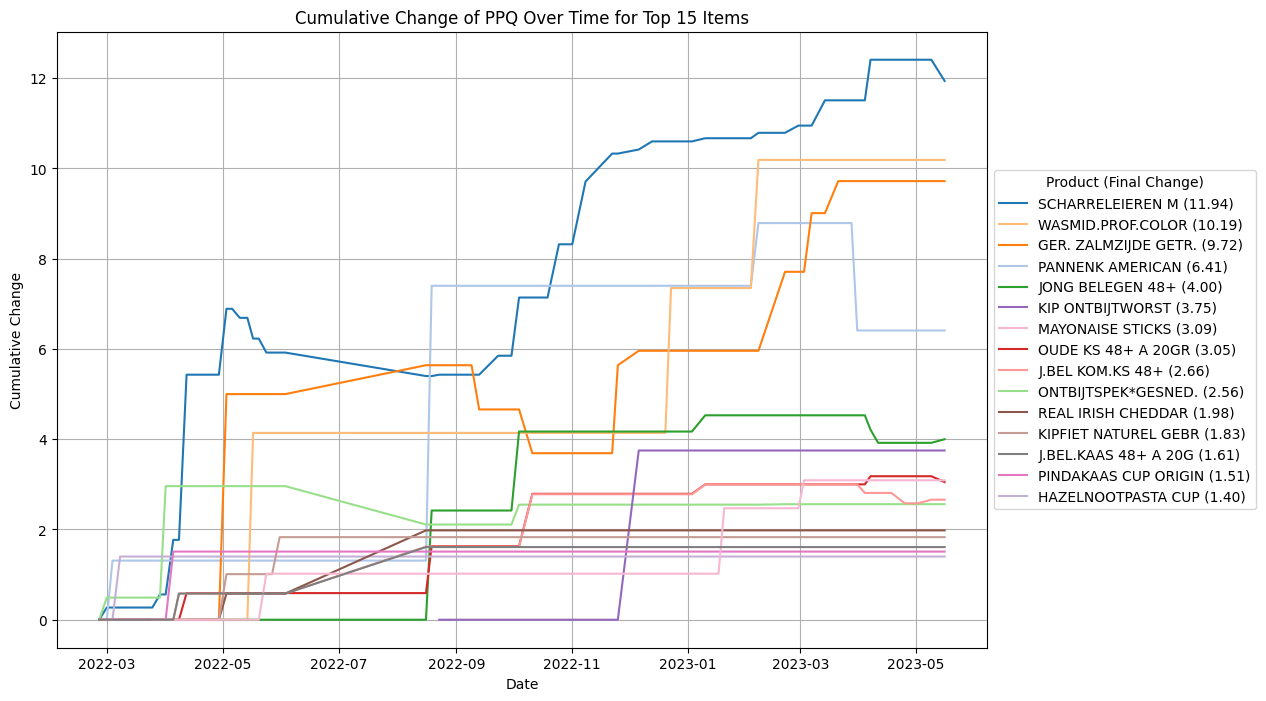

In [11]:
## TOP 15

# Calculate the cumulative change for each item
df_cum_change = df_pivot.ffill(axis=1).diff(axis=1).cumsum(axis=1)
df_cum_change = df_cum_change.loc[df_cum_change.abs().sum(axis=1) != 0]

# Select the top 15 items with the biggest cumulative changes
top_15_cum_changes = df_cum_change.abs().sum(axis=1).nlargest(15).index
#top_15_cum_changes = top_15_cum_changes.drop("MUESLI FRUIT-NOTEN")
df_top_15_cum_changes = df_cum_change.loc[top_15_cum_changes]
fig, ax = plt.subplots(figsize=(12, 8))
final_changes = []


# Define colors for lines and legend entries
colors = plt.cm.tab20(range(len(df_top_15_cum_changes.index)))

for idx, item in enumerate(df_top_15_cum_changes.index):
    line_color = colors[idx]
    line, = ax.plot(df_top_15_cum_changes.columns, df_top_15_cum_changes.loc[item], color=line_color)
    final_change = df_top_15_cum_changes.loc[item].iloc[-1]
    final_changes.append(final_change)
    line.set_label(f"{item} ({final_change:.2f})")

# Sort the legend labels by final changes
legend_labels = [line.get_label() for line in ax.lines]
sorted_legend_labels = [label for _, label in sorted(zip(final_changes, legend_labels), reverse=True)]
sorted_lines = [line for _, line in sorted(zip(final_changes, ax.lines), reverse=True)]

# Create a separate legend with sorted labels and final changes
plt.legend(handles=sorted_lines, labels=sorted_legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Product (Final Change)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Change')
ax.set_title('Cumulative Change of PPQ Over Time for Top 15 Items')
ax.grid(True)

plt.show()


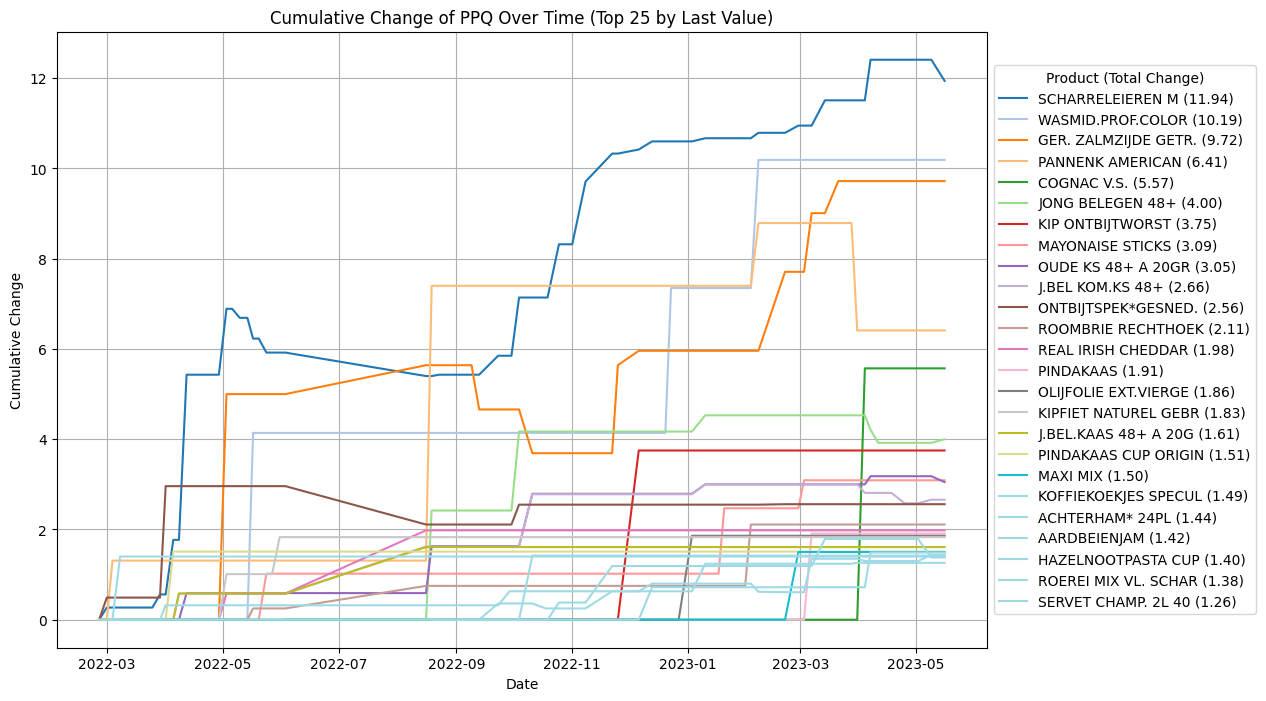

In [12]:
## TOP 25

# Calculate the cumulative change for each item
df_cum_change = df_pivot.ffill(axis=1).diff(axis=1).cumsum(axis=1)
df_cum_change = df_cum_change.loc[df_cum_change.abs().sum(axis=1) != 0]

# Get the last non NaN value for each item
last_values = df_cum_change.iloc[:, -1].dropna()

# Select the top 15 items with the biggest changes
top_15_items = last_values.nlargest(25).index

# Select only the top 15 items for plotting
df_top_15_cum_changes = df_cum_change.loc[top_15_items]
df_top_15_cum_changes.to_excel('top_25_cum_changes.xlsx',index=True)

fig, ax = plt.subplots(figsize=(12, 8))
final_changes = []

# Define colors for lines and legend entries
colors = plt.cm.tab20(range(len(df_top_15_cum_changes.index)))

for idx, item in enumerate(df_top_15_cum_changes.index):
    line_color = colors[idx]
    line, = ax.plot(df_top_15_cum_changes.columns, df_top_15_cum_changes.loc[item], color=line_color)
    final_change = last_values.loc[item]
    final_changes.append(final_change)
    line.set_label(f"{item} ({final_change:.2f}) ({}%)")

# Sort the legend labels by final changes
legend_labels = [line.get_label() for line in ax.lines]
sorted_lines = [line for _, line in sorted(zip(final_changes, ax.lines), key=lambda x: x[0], reverse=True)]
sorted_legend_labels = [label for _, label in sorted(zip(final_changes, legend_labels), key=lambda x: x[0], reverse=True)]

# Create a separate legend with sorted labels and final changes
plt.legend(sorted_lines, sorted_legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Product (Total Change)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Change')
ax.set_title('Cumulative Change of PPQ Over Time (Top 25 by Last Value)')
ax.grid(True)

plt.show()

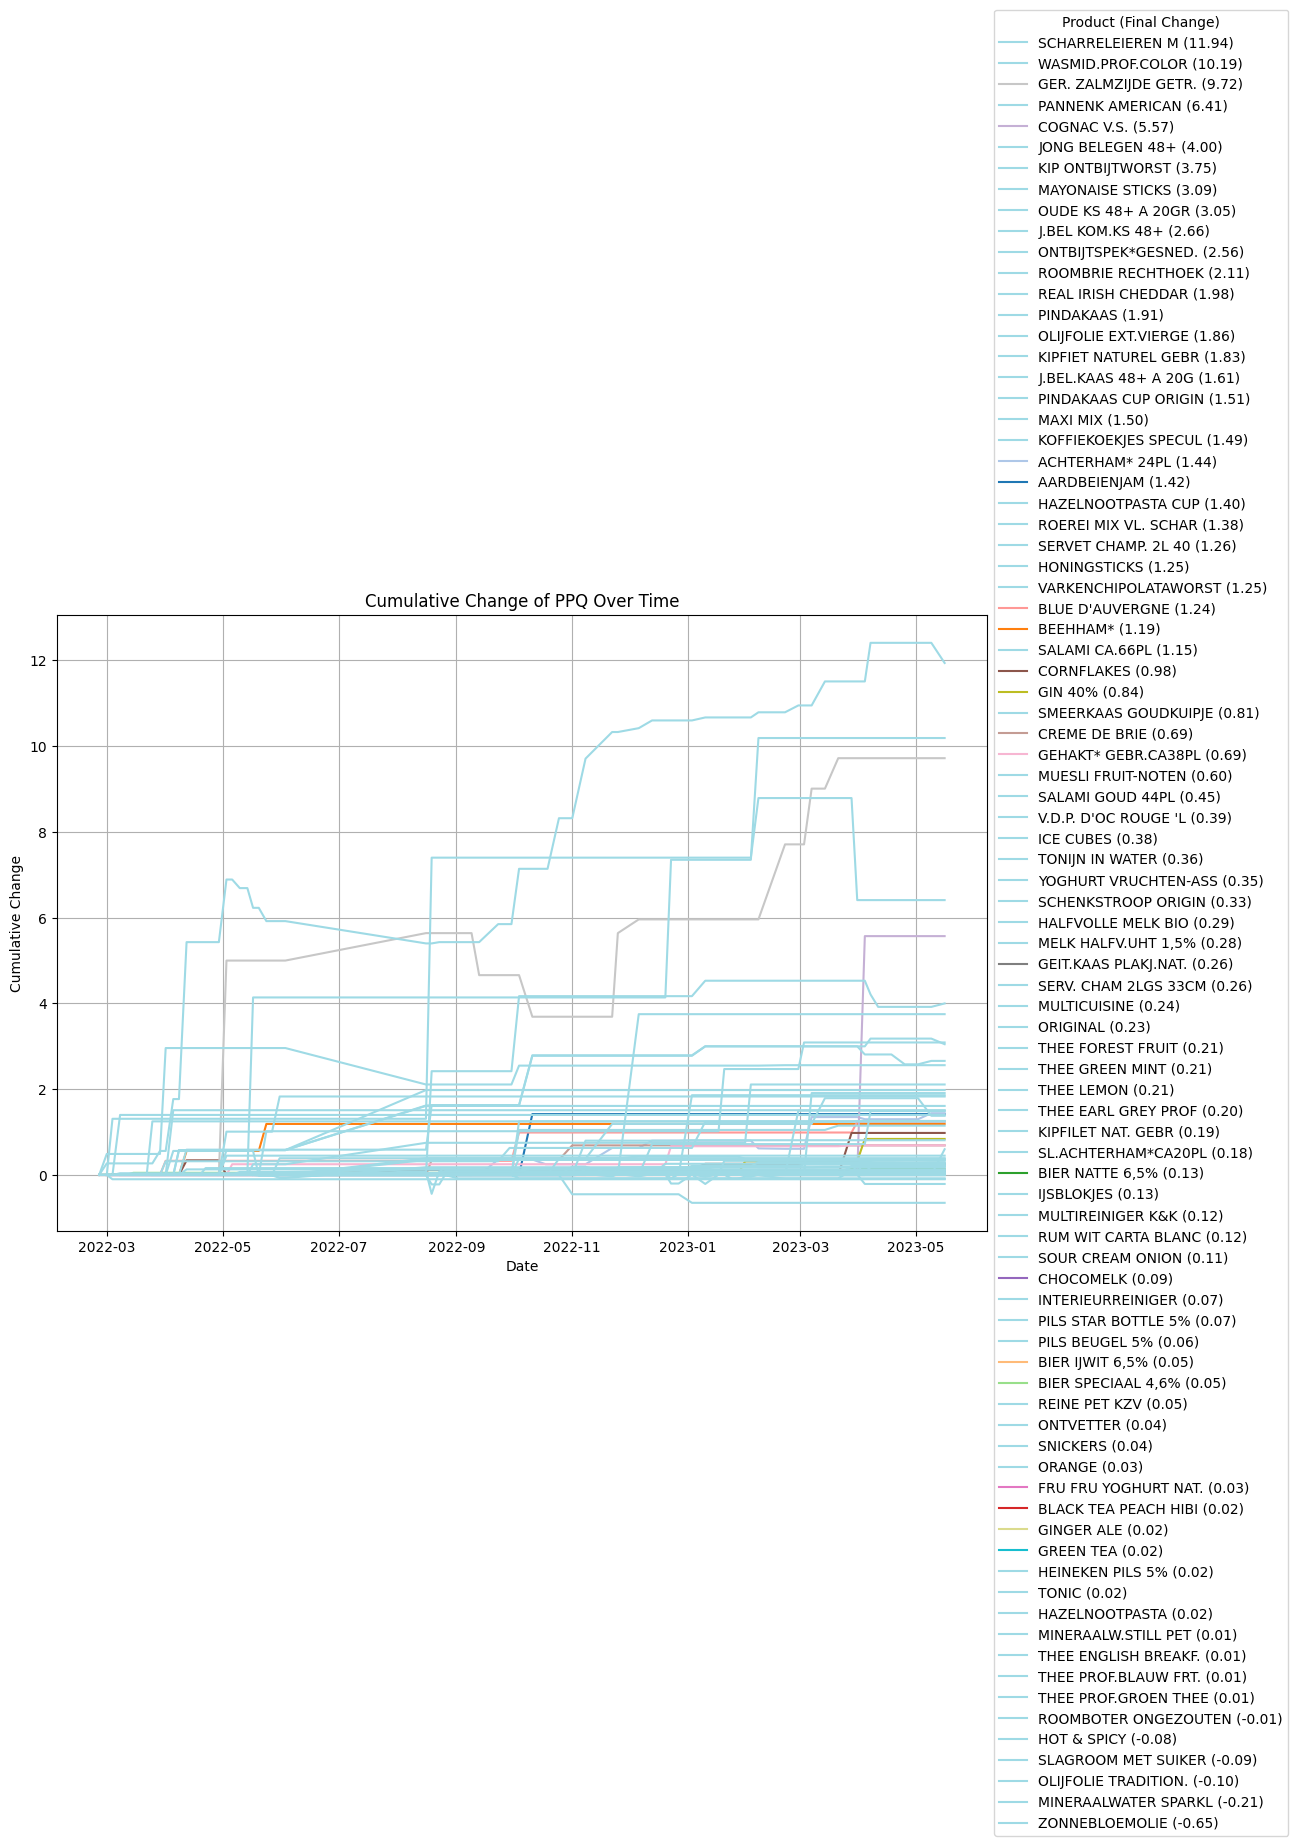

In [13]:
## ALL

# Calculate the cumulative change for each item
df_cum_change = df_pivot.ffill(axis=1).diff(axis=1).cumsum(axis=1)
df_cum_change = df_cum_change.loc[df_cum_change.abs().sum(axis=1) != 0]

# Select the top 15 items with the biggest cumulative changes
all_cum_changes = df_cum_change.abs().sum(axis=1).index
# top_15_cum_changes = top_15_cum_changes.drop("MUESLI FRUIT-NOTEN")
df_all_cum_changes = df_cum_change.loc[all_cum_changes]

fig, ax = plt.subplots(figsize=(12, 8))
final_changes = []

# Define colors for lines and legend entries
colors = plt.cm.tab20(range(len(df_all_cum_changes.index)))

for idx, item in enumerate(df_all_cum_changes.index):
    line_color = colors[idx]
    line, = ax.plot(df_all_cum_changes.columns, df_all_cum_changes.loc[item], color=line_color)
    final_change = df_all_cum_changes.loc[item].iloc[-1]
    final_changes.append(final_change)
    line.set_label(f"{item} ({final_change:.2f})")

# Sort the legend labels by final changes
legend_labels = [line.get_label() for line in ax.lines]
sorted_lines = [line for _, line in sorted(zip(final_changes, ax.lines), key=lambda x: x[0], reverse=True)]
sorted_legend_labels = [label for _, label in sorted(zip(final_changes, legend_labels), key=lambda x: x[0], reverse=True)]

# Create a separate legend with sorted labels and final changes
plt.legend(sorted_lines, sorted_legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Product (Final Change)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Change')
ax.set_title('Cumulative Change of PPQ Over Time')
ax.grid(True)

plt.show()


I am adding a feauture that was later requested: only plot a couple of items they want

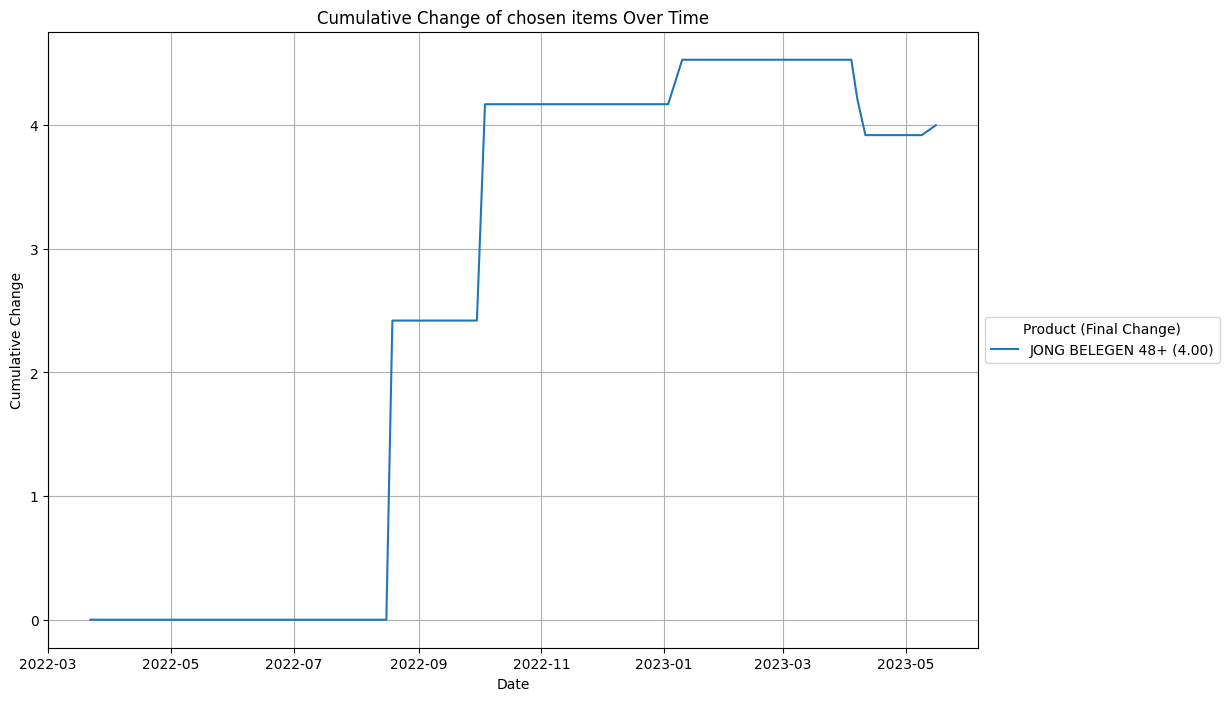

In [14]:
## CHOOSE ITEMS
items_choose=["JONG BELEGEN 48+"]
df_chosen_items = df_pivot.loc[items_choose]

# Calculate the cumulative change for each item
df_cum_change = df_chosen_items.ffill(axis=1).diff(axis=1).cumsum(axis=1)
df_cum_change = df_cum_change.loc[df_cum_change.abs().sum(axis=1) != 0]

# Select the top 15 items with the biggest cumulative changes
top_15_cum_changes = df_cum_change.abs().sum(axis=1).index
#top_15_cum_changes = top_15_cum_changes.drop("MUESLI FRUIT-NOTEN")
df_top_15_cum_changes = df_cum_change.loc[top_15_cum_changes]
fig, ax = plt.subplots(figsize=(12, 8))
final_changes = []


# Define colors for lines and legend entries
colors = plt.cm.tab20(range(len(df_top_15_cum_changes.index)))

for idx, item in enumerate(df_top_15_cum_changes.index):
    line_color = colors[idx]
    line, = ax.plot(df_top_15_cum_changes.columns, df_top_15_cum_changes.loc[item], color=line_color)
    final_change = df_top_15_cum_changes.loc[item].iloc[-1]
    final_changes.append(final_change)
    line.set_label(f"{item} ({final_change:.2f})")

# Sort the legend labels by final changes
legend_labels = [line.get_label() for line in ax.lines]
sorted_legend_labels = [label for _, label in sorted(zip(final_changes, legend_labels), reverse=True)]
sorted_lines = [line for _, line in sorted(zip(final_changes, ax.lines), reverse=True)]

# Create a separate legend with sorted labels and final changes
plt.legend(handles=sorted_lines, labels=sorted_legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Product (Final Change)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Change')
ax.set_title('Cumulative Change of chosen items Over Time')
ax.grid(True)

plt.show()


The following is the analysis of how the total changes over time and if there is a significant change. In the first graph we would notice by visual inspection that there is an obvious separation in the data between large and smaller bills. (It would later turn out that there really are two types of orders which are on the same invoice but need to be separated). I used both k-means clustering and visual inspection.

In [15]:
#df_total

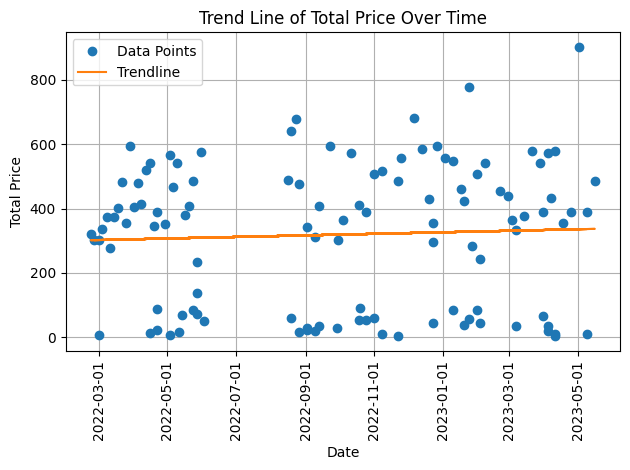

In [16]:
# Assuming your DataFrame has a 'date' column and a 'total_price' column
x = df_total['Date']
y = df_total['Total price']

# Fit a polynomial of degree 1 (linear regression)
coefficients = np.polyfit(mdates.date2num(x), y, deg=1)
trendline = np.polyval(coefficients, mdates.date2num(x))

# Plot the data points and the trendline
plt.plot(x, y, 'o', label='Data Points')
plt.plot(x, trendline, label='Trendline')

# Format x-axis ticks as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Total Price')
plt.title('Trend Line of Total Price Over Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


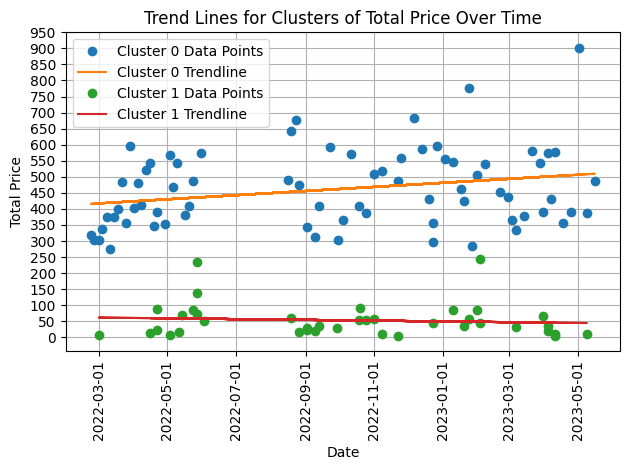

In [17]:
# Assuming your DataFrame has a 'date' column and a 'total_price' column
x = df_total['Date']
y = df_total['Total price']

# Convert date values to numeric format
x_numeric = mdates.date2num(x)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(y.values.reshape(-1, 1))
cluster_labels = kmeans.labels_

# Plot the data points and the trend lines for each cluster
for cluster_id in np.unique(cluster_labels):
    cluster_mask = cluster_labels == cluster_id
    x_cluster = x[cluster_mask]
    x_numeric_cluster = x_numeric[cluster_mask]
    y_cluster = y[cluster_mask]

    # Fit a polynomial of degree 1 (linear regression) for each cluster
    coefficients = np.polyfit(x_numeric_cluster, y_cluster, deg=1)
    trendline = np.polyval(coefficients, x_numeric_cluster)

    # Plot the data points and the trend line for the cluster
    plt.plot(x_cluster, y_cluster, 'o', label=f'Cluster {cluster_id} Data Points')
    plt.plot(x_cluster, trendline, label=f'Cluster {cluster_id} Trendline')

# Format x-axis ticks as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Total Price')
plt.title('Trend Lines for Clusters of Total Price Over Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1000, 50))
plt.tight_layout()
plt.show()


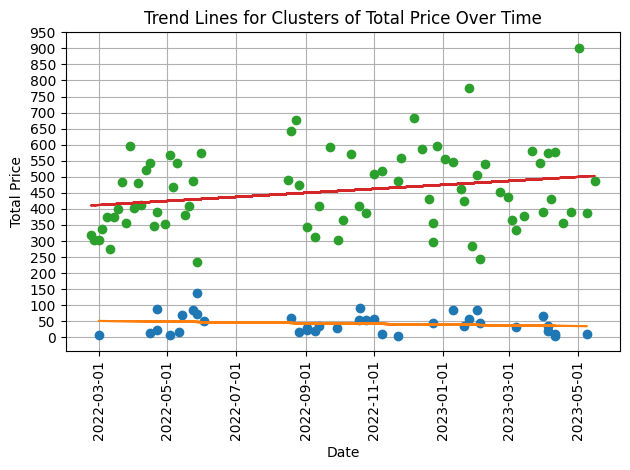

In [18]:

# Assuming your DataFrame has a 'date' column and a 'total_price' column
x = df_total['Date']
y = df_total['Total price']

# Convert date values to numeric format
x_numeric = mdates.date2num(x)

# Split the data based on the threshold of 100 EUR
threshold = 150
below_threshold_mask = y < threshold
above_threshold_mask = y >= threshold

x_below = x[below_threshold_mask]
x_numeric_below = x_numeric[below_threshold_mask]
y_below = y[below_threshold_mask]

x_above = x[above_threshold_mask]
x_numeric_above = x_numeric[above_threshold_mask]
y_above = y[above_threshold_mask]

# Fit a polynomial of degree 1 (linear regression) for each cluster
coefficients_below = np.polyfit(x_numeric_below, y_below, deg=1)
trendline_below = np.polyval(coefficients_below, x_numeric_below)

coefficients_above = np.polyfit(x_numeric_above, y_above, deg=1)
trendline_above = np.polyval(coefficients_above, x_numeric_above)

# Plot the data points and the trend lines for each cluster
plt.plot(x_below, y_below, 'o', label='Below 100 EUR Data Points')
plt.plot(x_below, trendline_below, label='Below 100 EUR Trendline')

plt.plot(x_above, y_above, 'o', label='Above 100 EUR Data Points')
plt.plot(x_above, trendline_above, label='Above 100 EUR Trendline')

# Format x-axis ticks as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Total Price')
plt.title('Trend Lines for Clusters of Total Price Over Time')
plt.grid(True)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1000, 50))
plt.tight_layout()
plt.show()


Now for the final part of this notebook I will answer my own question of which price increases contributed the most. Arguably there are many ways to do this, but the way I did it is to multiply the changes in price per the quantity ordered as they occur (i.e. if eggs increased with 1 EUR by 6 June but 10 EUR by today, the values before 6 June will be multiplied by 1 not 10)
and then do a ordered bar chart to visualise it.

In [19]:
df_quantity_pivot = df.reset_index().pivot_table(index='Item', columns='Date', values='Quantity').fillna(0)
df_quantity_pivot.to_excel('quantity_pivot.xlsx',index=True)
df_cum_change = df_pivot.ffill(axis=1).diff(axis=1).cumsum(axis=1).fillna(0)
df_cum_change_impact = pd.DataFrame(df_cum_change.values * df_quantity_pivot.values, columns=df_cum_change.columns, index=df_cum_change.index)
df_cum_change_weighted = df_cum_change_impact.sum(axis=1).sort_values(ascending=False)[:127]
#the waters were giving some strange results, additional research needed



In [20]:
overall_impact = df_cum_change_weighted.sum()
df_cum_change_weighted_pct = df_cum_change_weighted / overall_impact

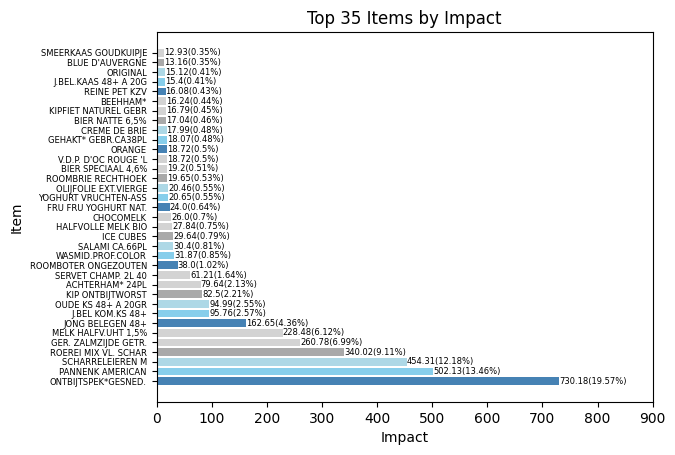

In [21]:

# Select top 15 items
top_15 = df_cum_change_weighted.head(35)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a bar plot with different colors
colors = ['steelblue', 'skyblue', 'lightblue', 'darkgray', 'lightgray', 'lightgray']
ax.barh(top_15.index, top_15.values, color=colors)

# Add arrows pointing to the top 15 items
for i, (item, impact) in enumerate(zip(top_15.index, top_15.values)):
 
    ax.text(impact, i, f"{round(impact,2)}({round(df_cum_change_weighted_pct.values[i]*100,2)}%)", ha='left', va='center',fontsize=6)

# Set y-axis ticks and labels
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15.index, fontsize=6)
ax.set_xlim(0,900)

# Set labels and title
ax.set_xlabel('Impact')
ax.set_ylabel('Item')
ax.set_title('Top 35 Items by Impact')

# Show the plot
plt.show()
